General notes:
- This is highlighting a further point that the perturbation stuff is really about full unitary/super op simulation. The benefits of this approach are most stark in that regime - for single state simulation it seems to not provide enough of a speed up (i.e. for unitary simulation we can observe more than 10x speed up (with right parameters I've seen more than 25x), but for single input state simulation it's more like 2-3x, which I don't personally think is enough to justify its use given the compilation cost)


3 is control, 5 is target

steps:
- compute the dressed frequencies

pulses:
- CR is gaussian square on control at "freq of target"
- Rotary echo is on target with "freq of target"
- Bipolar guassian square/antisymmetric thing is on target with "freq of target"


# This notebook

This notebook sets up an objective function for a CR gate in 3 ways:
- Using dense arrays
- Using sparse arrays
- Using a specialized Dyson-expansion based solver

and compare the speed of the three of these.

In [1]:
from time import time

import numpy as np
import scipy as sp

import jax.numpy as jnp
from jax import jit, grad, value_and_grad, vmap
from jax.scipy.special import erf
from jax.lax import cond, associative_scan
from jax.scipy.linalg import expm as jexpm
from jax.config import config
from jax.ops import index_update
config.update("jax_enable_x64", True)

from qiskit.quantum_info import Operator

from qiskit_dynamics import Solver, Signal
from qiskit_dynamics_internal.perturbation.perturbative_solvers import PerturbativeSolver

from qiskit_dynamics import dispatch
from qiskit_dynamics.array import Array

dispatch.set_default_backend('jax')

# 1. Define envelope functions

In [2]:
def gaussian_square(t, amp, sigma, risefall, T):
    """Gaussian square pulse."""
    
    t = Array(t).data
    C = jnp.exp(-(2*risefall*sigma)**2/(8*sigma**2))
    den = (jnp.sqrt(jnp.pi*2*sigma**2)*erf(2*risefall*sigma/(jnp.sqrt(8)*sigma))-2*risefall*sigma*C)
    return amp * jnp.piecewise(t,
                         condlist=[t < (risefall * sigma), (T - t) < (risefall * sigma)],
                         funclist=[lambda s: (jnp.exp(-(s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (jnp.exp(-(T-s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (1-C)/den]
                        )

def bipolar_gaussian_square(t, amp, sigma, risefall, T):
    t = Array(t).data
    unipolar = lambda s: gaussian_square(s, amp, sigma, risefall, T/2)
    return jnp.piecewise(t,
                         condlist=[t < (T/2)],
                         funclist=[unipolar, lambda s: -unipolar(s - T/2)])

Set some parameters.

In [3]:
T = 300.
risefall = 2.
sigma = 15.
amp=4.

test = jnp.vectorize(lambda t: bipolar_gaussian_square(t, amp, sigma, risefall, T))

sig = Signal(test)

## 1.1 Compare to original function

In [4]:
def pulseFunction(t,amp,T,sigma,risefall,shape="GaussianSquare"):
    if t>T: return 0
    elif shape=="GaussianSquare":
      C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
      den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
      if t<risefall*sigma:
        temp=amp*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
        return temp
      elif T-t<risefall*sigma: return amp*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      else: return amp*(1-C)/den
    elif shape=="BipolarGaussianSquare":
      C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
      den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
      if t<risefall*sigma:
        temp=amp*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
        return temp
      elif t<T/2-risefall*sigma: return amp*(1-C)/den
      elif t<T/2: return amp*(np.exp(-(T/2-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      elif t<T/2+risefall*sigma: return -1*amp*(np.exp(-((t-T/2)-sigma*risefall)**2/(2*sigma**2))-C)/den
      elif t<T-risefall*sigma: return -1*amp*(1-C)/den
      elif T-t<risefall*sigma: return -1*amp*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      else: return 0
    else: raise Exception('type: ' + shape + ' is unsupported :(')

In [5]:
sig2 = Signal(np.vectorize(lambda t: pulseFunction(t, amp, T, sigma, risefall, "BipolarGaussianSquare")))

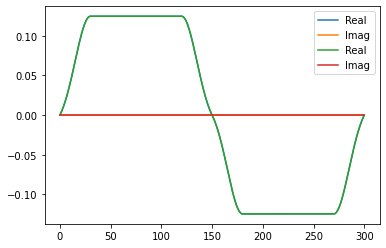

In [6]:
sig.draw(0, 300, 500, function='envelope')
sig2.draw(0, 300, 500, function='envelope')

# 2. Construct model operators

Input data

```
inputDict = {'systemDict': {'elementDict':
{0: {'label': 'q3', 'dim': 5, 'freq': 5.105,'anharmonicity': -0.33534, 'T1': 100.17, 'T2': 71.25},
1: {'label': 'q5', 'dim': 5, 'freq': 5.033, 'anharmonicity': -0.33834, 'T1': 79.34, 'T2': 71.89}},
'couplingDict': {0: {'label1': 'q10', 'label2': 'q12', 'strength': 0.002}}},
'gateDict': {'qubits': ['q3', 'q5'], 'sigma': 15, 'risefall': 2, 'gatetime'300}
```

In [7]:
w_c = 2 * np.pi * 5.105
w_t = 2 * np.pi * 5.033
alpha_c = 2 * np.pi * (-0.33534)
alpha_t = 2 * np.pi * (-0.33834)
J = 2 * np.pi * 0.002

dim = 5

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

In [8]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = 2 * np.pi * (a0 + adag0)
Hdt = 2 * np.pi * (a1 + adag1)

## 2.1 Diagonalize `H0` and extract computational states and frequencies

In [9]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

In [10]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B.transpose())
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B.transpose())
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B.transpose())
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B.transpose())

# "target dressed frequency"
v_t = E01 / (2 * np.pi)

Model operators in basis in which `H0` is diagonal.

In [11]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B
Hdt_B = Badj @ Hdt @ B

## 2.2 Construct Pauli operators for computational subspace

In [12]:
idx00 = 0
idx01 = get_dressed_state_index(0, 1, dim, B.transpose())
idx10 = get_dressed_state_index(1, 0, dim, B.transpose())
idx11 = get_dressed_state_index(1, 1, dim, B.transpose())

e00 = np.zeros(dim**2, dtype=complex)
e00[0] = 1.
e10 = np.zeros(dim**2, dtype=complex)
e10[idx10] = 1.
e01 = np.zeros(dim**2, dtype=complex)
e01[idx01] = 1.
e11 = np.zeros(dim**2, dtype=complex)
e11[idx11] = 1.

# set up observables
S = np.array([e00, e01, e10, e11]).transpose()
Sdag = S.conj().transpose()

II = S @ Sdag
IX = S @ np.array(Operator.from_label('IX')) @ Sdag
IY = S @ np.array(Operator.from_label('IY')) @ Sdag
IZ = S @ np.array(Operator.from_label('IZ')) @ Sdag
XI = S @ np.array(Operator.from_label('XI')) @ Sdag
XX = S @ np.array(Operator.from_label('XX')) @ Sdag
XY = S @ np.array(Operator.from_label('XY')) @ Sdag
XZ = S @ np.array(Operator.from_label('XZ')) @ Sdag
YI = S @ np.array(Operator.from_label('YI')) @ Sdag
YX = S @ np.array(Operator.from_label('YX')) @ Sdag
YY = S @ np.array(Operator.from_label('YY')) @ Sdag
YZ = S @ np.array(Operator.from_label('YZ')) @ Sdag
ZI = S @ np.array(Operator.from_label('ZI')) @ Sdag
ZX = S @ np.array(Operator.from_label('ZX')) @ Sdag
ZY = S @ np.array(Operator.from_label('ZY')) @ Sdag
ZZ = S @ np.array(Operator.from_label('ZZ')) @ Sdag

# 3. Dense simulation and optimization

For dense simulation, we work in the basis in which `H0` is diagonal, and simulate in the frame of the static hamiltonian.

Question: should the initial state here actually just be `S` since we only care about the computational subspace? Could affect scaling quite a bit.

In [13]:
dense_solver = Solver(static_hamiltonian=H0_B,
                      hamiltonian_operators=[Hdc_B, Hdt_B],
                      rotating_frame=H0_B)

y0 = np.eye(dim**2, dtype=complex)

def full_sim(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    solver_copy = dense_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0,
                                method='jax_odeint')
    
    U = results.y[-1]

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


Construct fidelity function to target unitary.

In [14]:
target = S @ jexpm(-1j * np.array(Operator.from_label('ZX')) * jnp.pi / 4) @ Sdag
target_conj = target.conj()

def fidelity(U):
    return jnp.abs(jnp.sum(target_conj * U))**2 / (4**2)

Construct full objective function.

In [15]:
def obj(x):
    # extract parameters
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]
    
    # run simulation
    U = full_sim(amps, phases, pre_rot, post_rot)
    
    # compute fidelity
    return 1 - fidelity(U)

# compile and differentiate
jit_obj = jit(obj)
grad_obj = jit(value_and_grad(obj))

## 3.1 Time to compute objective and gradients

Time to compute objective.

In [16]:
x0=jnp.array([1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.])

start = time()
jit_obj(x0).block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
jit_obj(x0).block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 6.550750970840454
compiled simulation time: 2.2274842262268066


Time to compute gradient.

In [17]:
start = time()
grad_obj(x0)[0].block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
grad_obj(x0)[0].block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 17.697789907455444
compiled simulation time: 6.861664056777954


## 3.2 Optimize the objective

I don't know how important this actually is - the speed of the computation is the most important.

In [18]:
from scipy.optimize import minimize

# initial guess
x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

start = time()
# needs x vals need to be 1d
res = minimize(grad_obj, x0=x0, method='BFGS', jac=True)
print('time taken: ' + str(time() - start))

print(res)

time taken: 697.4565000534058
      fun: 0.00015802292366406956
 hess_inv: array([[ 1.41694852e+02, -1.54001469e+00, -1.20833151e+00,
        -4.99960991e+01, -8.16764011e+00,  4.79920304e+01,
        -1.12911742e+01,  1.08067201e+03,  1.04699669e+01,
         1.08067201e+03],
       [-1.54001469e+00,  3.57372210e-02,  2.35467117e-02,
         2.87785565e-01,  7.13197275e-01, -7.64158835e-01,
         2.55264597e-01, -1.17358890e+01, -2.34178799e-01,
        -1.17358890e+01],
       [-1.20833151e+00,  2.35467117e-02,  8.24678008e-02,
         3.07500180e-01,  3.95393304e-01, -5.12874463e-01,
         2.12811486e-01, -9.21973169e+00, -1.79483026e-01,
        -9.21973169e+00],
       [-4.99960991e+01,  2.87785565e-01,  3.07500180e-01,
         2.20249633e+01, -6.12303779e+00, -1.32307736e+01,
         1.97860442e+00, -3.81372103e+02, -1.85944795e+00,
        -3.81372103e+02],
       [-8.16764011e+00,  7.13197275e-01,  3.95393304e-01,
        -6.12303779e+00,  2.37264207e+01, -1.14727227e

# 3. Sparse simulation and optimization

Simulation with sparse arrays needs to be setup in the standard basis, and simulated in the frame of the diagonal of `H0`, rather than all of `H0`, to preserve sparsity.

In [19]:
sparse_solver = Solver(static_hamiltonian=H0,
                       hamiltonian_operators=[Hdc, Hdt],
                       rotating_frame=np.diag(H0),
                       evaluation_mode='sparse')

# simulate the identity
y0_sparse = B @ y0

def full_sim_sparse(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()

    solver_copy = sparse_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0_sparse,
                                method='jax_odeint')
    
    U = results.y[-1]
    
    # convert to correct frame/basis
    # take U out of current frame
    U = Array(Badj) @ solver_copy.model.rotating_frame.state_out_of_frame(T, U)
    # put U into same frame as dense, in the same basis
    U = Array(dense_solver.model.rotating_frame.state_into_frame(T, U)).data

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


Set up objective.

In [20]:
def full_sim_U_sparse(x):
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]
    
    U = full_sim_sparse(amps, phases, pre_rot, post_rot)
    return U

def obj_sparse(x):
    U = full_sim_U_sparse(x)
    
    return 1 - fidelity(U)

# compile and differentiate
jit_obj_sparse = jit(obj_sparse)
grad_obj_sparse = jit(value_and_grad(obj_sparse))

## 4.1 Time to compute objective and gradients

Time to compute objective.

In [21]:
x0=jnp.array([1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.])

start = time()
jit_obj_sparse(x0).block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
jit_obj_sparse(x0).block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 5.823290109634399
compiled simulation time: 1.827211856842041


Time to compute gradient.

In [22]:
start = time()
grad_obj_sparse(x0)[0].block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
grad_obj_sparse(x0)[0].block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 23.192317962646484
compiled simulation time: 6.97125506401062


## 4.2 Optimize the objective

Is this necessary?

In [23]:
x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

start = time()
# needs x vals need to be 1d
sparse_res = minimize(grad_obj_sparse, x0=x0, method='BFGS', jac=True)
print('time taken: ' + str(time() - start))

print(res)

time taken: 627.8860149383545
      fun: 0.00015802292366406956
 hess_inv: array([[ 1.41694852e+02, -1.54001469e+00, -1.20833151e+00,
        -4.99960991e+01, -8.16764011e+00,  4.79920304e+01,
        -1.12911742e+01,  1.08067201e+03,  1.04699669e+01,
         1.08067201e+03],
       [-1.54001469e+00,  3.57372210e-02,  2.35467117e-02,
         2.87785565e-01,  7.13197275e-01, -7.64158835e-01,
         2.55264597e-01, -1.17358890e+01, -2.34178799e-01,
        -1.17358890e+01],
       [-1.20833151e+00,  2.35467117e-02,  8.24678008e-02,
         3.07500180e-01,  3.95393304e-01, -5.12874463e-01,
         2.12811486e-01, -9.21973169e+00, -1.79483026e-01,
        -9.21973169e+00],
       [-4.99960991e+01,  2.87785565e-01,  3.07500180e-01,
         2.20249633e+01, -6.12303779e+00, -1.32307736e+01,
         1.97860442e+00, -3.81372103e+02, -1.85944795e+00,
        -3.81372103e+02],
       [-8.16764011e+00,  7.13197275e-01,  3.95393304e-01,
        -6.12303779e+00,  2.37264207e+01, -1.14727227e

# 5. Simulate with Dyson solver

We now setup the problem to simulate the Dyson solver. The parameters of the solver have been reached by playing around with parameters to get a reasonable agreement. 

We initialize the solver, which involves an expensive pre-computation step.

In [24]:
# system information
generator_decomp = [-1j  * Hdc_B, -1j * Hdt_B]
carrier_freqs = [v_t, v_t]
frame_operator = -1j * H0_B

# approximation specification:
# chebyshev order to use
polynomial_degrees = [1, 1]
# Dyson series order to go to
perturbation_order = 6


# we will use 
n_steps = 600
dt = T / n_steps

start = time()
dyson_solver_jax = PerturbativeSolver(generator_decomp, 
                                       frame_operator,
                                       dt,
                                       carrier_freqs,
                                       polynomial_degrees,
                                       perturbation_method='dyson',
                                       perturbation_order=perturbation_order,
                                       method='jax_odeint',
                                       atol=1e-8,
                                       rtol=1e-8)
print(time() - start)

/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


675.3587119579315


Set up simulation function with this solver.

In [25]:
y0 = np.eye(dim**2, dtype=complex)

def dyson_sim(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    cr_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T)), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T)), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(jnp.vectorize(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T)), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    #import pdb; pdb.set_trace()
    U = dyson_solver_jax.solve([cr_signal, target_signal], y0, 0, n_steps)

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


Construct, compile, and differentiate objective.

In [26]:
def dyson_obj(x):
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]

    U = dyson_sim(amps, phases, pre_rot, post_rot)
    
    return 1 - fidelity(U)

jit_dyson_obj = jit(dyson_obj)
grad_dyson_obj = jit(value_and_grad(dyson_obj))

## 5.1 Time to compute objective and gradients

The objective.

In [27]:
x0=jnp.array([1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.])

start = time()
jit_dyson_obj(x0).block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
jit_dyson_obj(x0).block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 7.26019811630249
compiled simulation time: 0.10149502754211426


Gradient of the objective.

In [28]:
x0=jnp.array([1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.])

start = time()
grad_dyson_obj(x0)[0].block_until_ready()
print('compile + simulate time: ' + str(time() - start))

start = time()
grad_dyson_obj(x0)[0].block_until_ready()
print('compiled simulation time: ' + str(time() - start))

compile + simulate time: 21.03835701942444
compiled simulation time: 0.22298502922058105


Compare values to ensure consistency.

In [29]:
jit_dyson_obj(x0)

DeviceArray(0.15898691, dtype=float64)

In [30]:
jit_obj(x0)

DeviceArray(0.15897535, dtype=float64)

## 5.2 Optimize

Is this necessary?

In [31]:
x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

start = time()
# needs x vals need to be 1d
perturb_res = minimize(grad_dyson_obj, x0=x0, method='BFGS', jac=True)
print('time taken: ' + str(time() - start))

print(perturb_res)

time taken: 16.466931104660034
      fun: 0.0001678414174843823
 hess_inv: array([[ 2.05425422e+02, -1.93509314e+00, -2.14988115e+00,
        -7.63157118e+01, -1.32724135e+00,  6.50950186e+01,
        -1.32750538e+01,  1.56274605e+03,  1.30404875e+01,
         1.56274605e+03],
       [-1.93509314e+00,  3.90547834e-02,  2.78908482e-02,
         4.46812469e-01,  6.93569497e-01, -8.82210389e-01,
         2.78769445e-01, -1.47207274e+01, -2.49102833e-01,
        -1.47207274e+01],
       [-2.14988115e+00,  2.78908482e-02,  9.54633851e-02,
         7.24259388e-01,  2.67469394e-01, -7.73728974e-01,
         2.40385603e-01, -1.63565077e+01, -2.08366291e-01,
        -1.63565077e+01],
       [-7.63157118e+01,  4.46812469e-01,  7.24259388e-01,
         3.28964902e+01, -9.08792606e+00, -2.01911272e+01,
         2.69657191e+00, -5.80565657e+02, -2.99083918e+00,
        -5.80565657e+02],
       [-1.32724135e+00,  6.93569497e-01,  2.67469394e-01,
        -9.08792606e+00,  2.52029237e+01, -1.00308577e

# 6. Comparing values

These start to deviate around 5 decimal places, which may actually be on the order of the accuracy of the ODE solver itself that we computed things at.

In [32]:
print(dyson_obj(res.x))
print(dyson_obj(perturb_res.x))

0.00016784951963288997
0.0001678414174823839


In [33]:
print(obj(res.x))
print(obj(perturb_res.x))

0.00015802292366406956
0.0001580316022478101
